In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import time
import copy

In [ ]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 64
validation_ratio = 0.1
random_seed = 10

In [ ]:
data_transforms = {
    'train': transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]),

    'val': transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
}

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


train_val_datasets = {x: torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=data_transforms[x]) for x in ['train', 'val']}
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

num_train = len(train_val_datasets['train'])
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

sample = {
    'train': indices[split:],
    'val': indices[:split]
}

train_val_loaders = {x: torch.utils.data.DataLoader(train_val_datasets[x], batch_size=batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(sample[x])) for x in ['train', 'val']}

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):

  best_model = copy.deepcopy(model.state_dict())
  best_val = -1

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() 
      else:
        model.eval()  #
      
      running_loss = 0.0
      running_corrects = 0

      for i, (x, y) in enumerate(train_val_loaders[phase]):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # train일때만 학습
        with torch.set_grad_enabled(phase == 'train'):
          scores = model(x)
          loss = criterion(scores, y)
          _, preds = scores.max(1)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss * x.size(0)
        running_corrects += (preds == y).sum()

      # train일때만 learning rate도 변환
      if phase == 'train':
        scheduler.step()

      # loss와 accuracy 
      if phase == 'train':
        epoch_loss = running_loss / len(sample['train'])
        epoch_acc = running_corrects.double() / len(sample['train'])
      else : 
        epoch_loss = running_loss / len(sample['val'])
        epoch_acc = running_corrects.double() / len(sample['val'])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format( phase, epoch_loss, epoch_acc))
      

      if phase == 'val' and epoch_acc > best_val:
        best_val = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    
      print()

  # best model 가져옴
  model.load_state_dict(best_model)
  return model

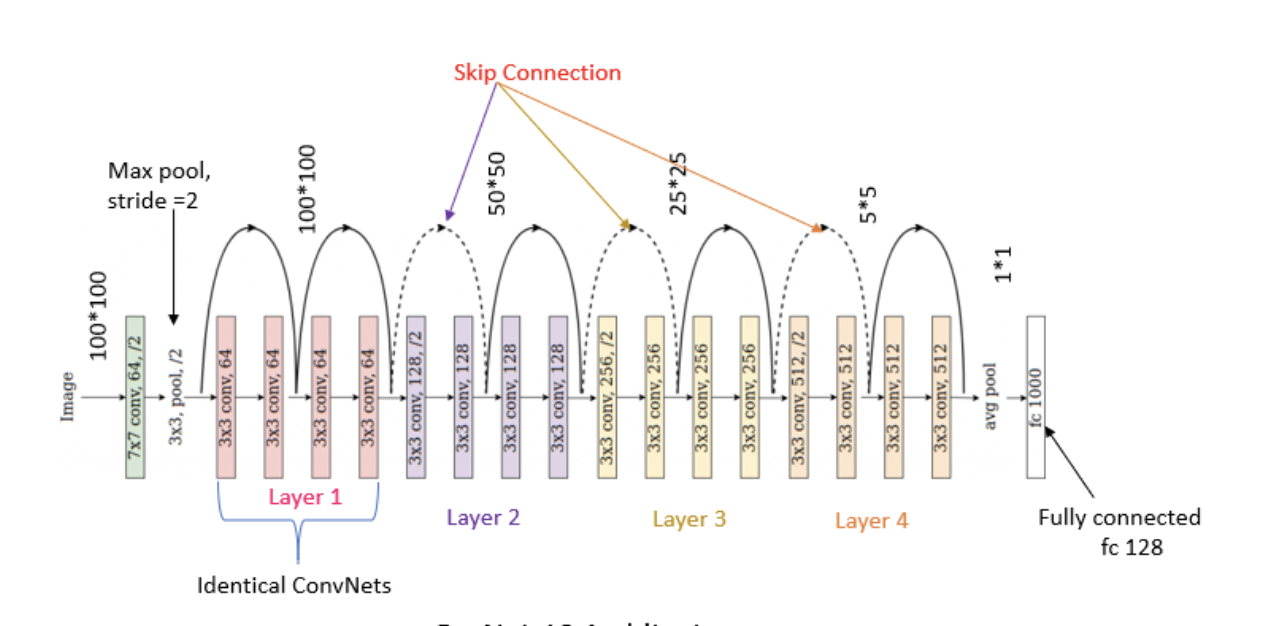

In [ ]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")


resnet18_ft = torchvision.models.resnet18(pretrained=True, progress=True)
num_features = resnet18_ft.fc.in_features
resnet18_ft.fc = nn.Linear(num_features, 10) 

criterion = nn.CrossEntropyLoss()

resnet18_ft = resnet18_ft.to(device)

optimizer_ft = torch.optim.Adam(resnet18_ft.parameters(), lr=0.0005, weight_decay=1e-4) 

# 지정한 스텝 단위로 학습률에 감마를 곱해 학습률을 감소시키는 방식
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

new_model_ft = train_model(resnet18_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50, device=device)


Epoch 0/49
----------
train Loss: 1.1213 Acc: 0.6170

val Loss: 0.9986 Acc: 0.6720

Epoch 1/49
----------
train Loss: 0.8290 Acc: 0.7195

val Loss: 0.7064 Acc: 0.7642

Epoch 2/49
----------
train Loss: 0.7336 Acc: 0.7501

val Loss: 0.8104 Acc: 0.7322

Epoch 3/49
----------
train Loss: 0.6862 Acc: 0.7675

val Loss: 0.7270 Acc: 0.7520

Epoch 4/49
----------
train Loss: 0.6454 Acc: 0.7804

val Loss: 0.6549 Acc: 0.7840

Epoch 5/49
----------
train Loss: 0.6132 Acc: 0.7924

val Loss: 0.5509 Acc: 0.8128

Epoch 6/49
----------
train Loss: 0.5749 Acc: 0.8059

val Loss: 0.6118 Acc: 0.7920

Epoch 7/49
----------
train Loss: 0.4475 Acc: 0.8457

val Loss: 0.4452 Acc: 0.8556

Epoch 8/49
----------
train Loss: 0.3995 Acc: 0.8622

val Loss: 0.4365 Acc: 0.8552

Epoch 9/49
----------
train Loss: 0.3795 Acc: 0.8680

val Loss: 0.4315 Acc: 0.8590

Epoch 10/49
----------
train Loss: 0.3628 Acc: 0.8742

val Loss: 0.4262 Acc: 0.8572

Epoch 11/49
----------
train Loss: 0.3533 Acc: 0.8774

val Loss: 0.4189 Acc

In [ ]:
new_model_ft.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)

        outputs = new_model_ft(images)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    print('Accuracy of Test: {} %'.format(100 * correct / total))


Accuracy of Test: 86.16 %
